# WandB 

In [61]:
import wandb
import pandas as pd

groups = ['zeb/childes-segmentation-100k', 'zeb/childes-segmentation-700k', 'zeb/childes-segmentation-2M', 'zeb/childes-segmentation-18M']

api = wandb.Api()

group_data = {}

for group in groups:
    runs = api.runs(group)

    data = []
    untrained_data = []
    for run in runs:
        config = run.config
        metrics = run.summary_metrics
        data.append({**config, **metrics})

        # Get first run
        history = run.scan_history()
        first_step = list(history)[0]
        for col in list(first_step.keys()):
            if 'eval' in col and 'best' not in col:
                new_col = col.replace('eval/', 'eval/best_')
                first_step[new_col] = first_step[col]
        untrained_data.append({**config, **first_step})

    # Average all scores in untrained_data
    untrained_avg = {}
    for i, run in enumerate(untrained_data):
        for key, value in run.items():
            if not('eval/best' in key and 'boundary_fscore' in key):
                continue
            data[i][key] -= value
            if key not in untrained_avg:
                untrained_avg[key] = []
            untrained_avg[key].append(value)
    untrained_avg = {key: sum(value) / len(value) for key, value in untrained_avg.items()}
    untrained_avg['name'] = 'untrained'
    
    data = sorted(data, key=lambda x: x['name'])
    data.append(untrained_avg)

    df = pd.DataFrame(data)

    for col in df.columns:
        if col != 'name' and not ('eval/best' in col and 'boundary_fscore' in col):
            df = df.drop(col, axis=1)

    group_data[group] = df


In [58]:
group_data['zeb/childes-segmentation-700k']

,name,eval/best_absolute_seg_boundary_fscore_Boundary Prediction,eval/best_absolute_seg_boundary_fscore_Entropy,eval/best_absolute_seg_boundary_fscore_Increase in Boundary Prediction,eval/best_absolute_seg_boundary_fscore_Increase in Entropy,eval/best_absolute_seg_boundary_fscore_Increase in Loss,eval/best_absolute_seg_boundary_fscore_Increase in Rank,eval/best_absolute_seg_boundary_fscore_Loss,eval/best_absolute_seg_boundary_fscore_Majority Vote Cutoff,eval/best_absolute_seg_boundary_fscore_Majority Vote Spike,...,eval/best_spike_seg_boundary_fscore_Boundary Prediction,eval/best_spike_seg_boundary_fscore_Entropy,eval/best_spike_seg_boundary_fscore_Increase in Boundary Prediction,eval/best_spike_seg_boundary_fscore_Increase in Entropy,eval/best_spike_seg_boundary_fscore_Increase in Loss,eval/best_spike_seg_boundary_fscore_Increase in Rank,eval/best_spike_seg_boundary_fscore_Loss,eval/best_spike_seg_boundary_fscore_Majority Vote Cutoff,eval/best_spike_seg_boundary_fscore_Majority Vote Spike,eval/best_spike_seg_boundary_fscore_Rank
0,Cantonese,0.881609,0.630929,0.877985,0.716981,0.530660,0.620258,0.626078,0.788181,0.745859,...,0.830484,0.681044,0.829372,0.772120,0.707581,0.635025,0.606061,0.851249,0.795875,0.537572
1,Dutch,0.759806,0.667183,0.772122,0.800503,0.738272,0.705479,0.603774,0.820200,0.806264,...,0.785515,0.756025,0.779394,0.770281,0.736970,0.705568,0.666940,0.823234,0.773089,0.661119
2,English,0.739875,0.625537,0.421242,0.746863,0.739834,0.695529,0.594290,0.763901,0.800192,...,0.786108,0.729186,0.757500,0.735652,0.739018,0.687410,0.671347,0.793419,0.762553,0.638572
3,EnglishUK,0.735162,0.652975,0.442905,0.762201,0.720856,0.680073,0.604464,0.766082,0.798731,...,0.796509,0.752151,0.773991,0.760968,0.733061,0.679452,0.684715,0.790231,0.770959,0.642350
4,Estonian,0.711795,0.598639,0.740803,0.689727,0.648110,0.632981,0.543676,0.761619,0.737855,...,0.719968,0.650067,0.699921,0.649383,0.626964,0.622139,0.553766,0.748768,0.659412,0.550567
5,French,0.696663,0.662404,0.725000,0.703622,0.677080,0.648750,0.613856,0.749024,0.704715,...,0.739649,0.679582,0.729210,0.688235,0.658002,0.624142,0.604294,0.738868,0.713666,0.585654
6,German,0.466426,0.647090,0.734479,0.747851,0.710472,0.674781,0.576284,0.770248,0.787192,...,0.740360,0.715673,0.720736,0.710823,0.691775,0.666341,0.655694,0.783746,0.733051,0.619805
7,Indonesian,0.748072,0.647169,0.754569,0.718201,0.704532,0.680879,0.568355,0.781733,0.695795,...,0.618199,0.620795,0.600365,0.558227,0.630445,0.646707,0.631955,0.707945,0.614735,0.649914
8,Italian,0.705593,0.713295,0.356542,0.730286,0.648109,0.627583,0.607101,0.742681,0.687983,...,0.621027,0.678112,0.608800,0.652790,0.588706,0.607000,0.584218,0.708669,0.614357,0.595541
9,Japanese,0.726832,0.580317,0.728856,0.656031,0.612953,0.581465,0.515911,0.735849,0.652452,...,0.579287,0.593069,0.571429,0.570513,0.572519,0.597270,0.557037,0.691176,0.590253,0.581311


In [56]:
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

size_map = {
    '100k': 'Tiny',
    '700k': 'Small',
    '2M': 'Medium',
    '18M': 'Large'
}

def plot_heatmap(df, columns, seg_type, average=False):
    y_cols = [col for col in df.columns if seg_type in col]
    y = df[y_cols]
    y_col_labels = [col.split('_')[-1] for col in y_cols]
    y.columns = y_col_labels
    y = y[columns]
    if average:
        y['Average'] = y.mean(axis=1)
    x = df['name']

    y_col_labels = [col.split('_')[-1] for col in y_cols]
    y = y.T

    plot_ratio = len(df['name'].unique()) / len(y_col_labels)

    plt.figure(figsize=(12, 6 / plot_ratio))
    sns.set(font_scale=1.2)

    cmap = sns.color_palette("rocket_r", as_cmap=True)
    ax = sns.heatmap(y * 100, annot=True, fmt=".0f", xticklabels=x, cmap=cmap, vmin=40, vmax=90, linecolor='black', linewidth=0.2,
                    cbar_kws={'label': 'F1 Score', 'orientation': 'vertical', 'aspect': 10})
    plt.show()

def plot_comparison_heatmap(columns, seg_type, language):
    plt_data = pd.DataFrame()
    for group, df in group_data.items():
        # Filter by language
        tmp_df = df[df['name'] == language]
        tmp_df['name'] = group.split('-')[-1]
        plt_data = pd.concat([plt_data, tmp_df])
    plot_heatmap(plt_data, columns, seg_type, average=False)

def plot_lines(columns, seg_type, languages):
    plt_data = pd.DataFrame()
    for group, df in group_data.items():
        for language in languages:
            tmp_df = df[df['name'] == language]
            tmp_df['size'] = group.split('-')[-1]
            tmp_df['size_num'] = tmp_df['size'].str.replace('M', '000000').str.replace('k', '000').astype(int)
            tmp_df['size'] = tmp_df['size'].map(size_map)
            y_cols = [col for col in tmp_df.columns if seg_type in col]
            y = tmp_df[y_cols]
            y_col_labels = [col.split('_')[-1] for col in y_cols]
            y.columns = y_col_labels
            y = y[columns]
            maximum = y.max(axis=1)
            tmp_df['max'] = maximum * 100
            tmp_df = tmp_df[['max', 'size', 'name', 'size_num']]
            plt_data = pd.concat([plt_data, tmp_df])
    # Sort by name
    plt_data = plt_data.sort_values(by='name').sort_values(by='size_num')
    # Remove names that only appear once
    for name in plt_data['name'].unique():
        if len(plt_data[plt_data['name'] == name]) == 1:
            plt_data = plt_data[plt_data['name'] != name]
    
    plt.figure(figsize=(9, 7))
    sns.set(font_scale=2)
    sns.lineplot(data=plt_data,
                  x='size',
                  y='max',
                  hue='name',
                  # Legend outside of plot
                  legend='full',

                  # Different markers
                    style='name',
                    markers=True,
                    dashes=False,
                    # Smaller markers
                    markersize=10)
    
    plt.ylabel('F1 Score')
    plt.xlabel('Suite Size')
    # Legend outside of plot
    plt.legend(fontsize='xx-small', loc='lower right', ncol=2)

    plt.show()
    

/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_9806/1598029203.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['size'] = group.split('-')[-1]
/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_9806/1598029203.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['size_num'] = tmp_df['size'].str.replace('M', '000000').str.replace('k', '000').astype(int)
/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_9806/1598029203.py:52: SettingWithCopyWarning: 
A value is t

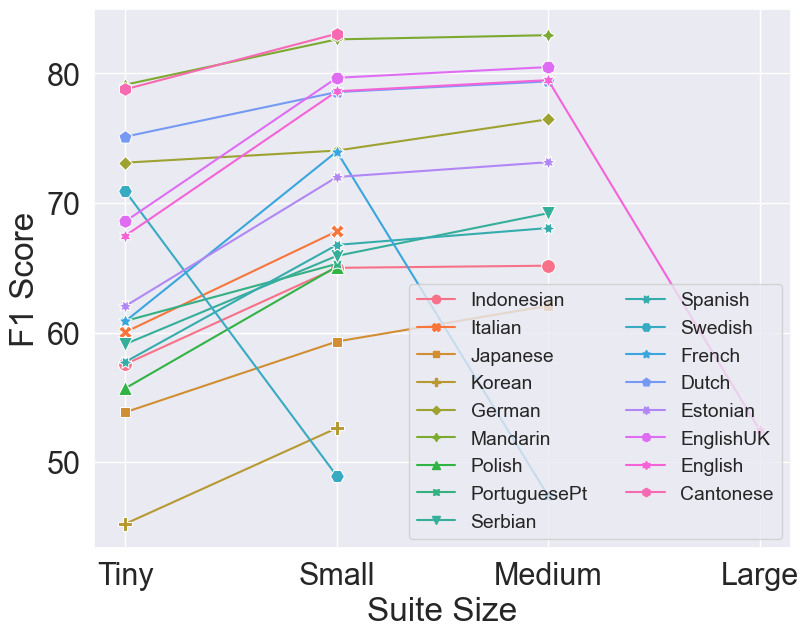

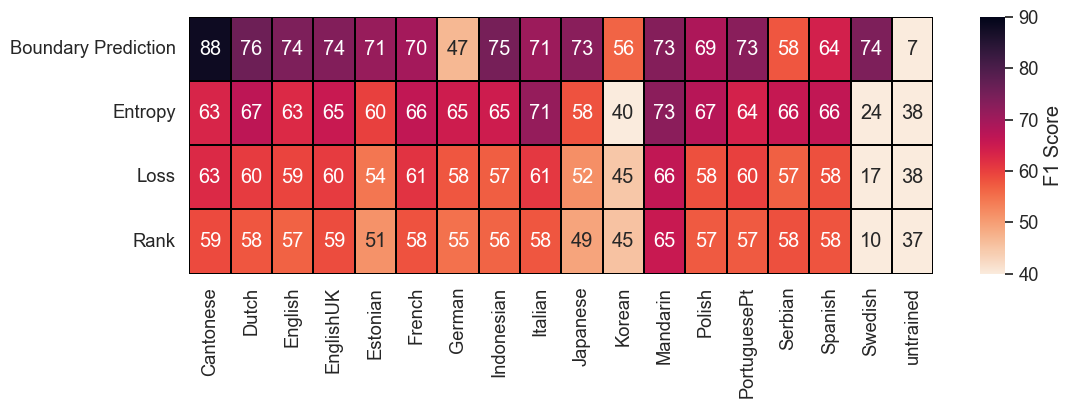

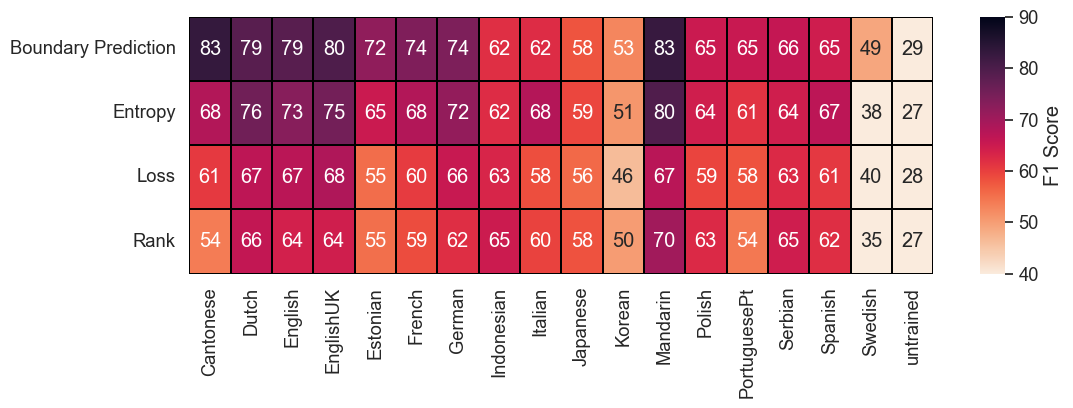

In [57]:
columns = ['Boundary Prediction',
                #'Increase in Boundary Prediction',
                'Entropy',
                #'Increase in Entropy',
                'Loss',
                #'Increase in Loss',
                'Rank',
                #'Increase in Rank',
                #'Majority Vote Cutoff',
                #'Majority Vote Spike',
                ]

all_languages = set([name for d in group_data.values() for name in d['name'].unique()])
all_languages.remove('untrained')
plot_lines(columns, 'spike', all_languages)

plot_heatmap(group_data[groups[1]], columns, 'absolute')
plot_heatmap(group_data[groups[1]], columns, 'spike')


/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_9806/565974344.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['name'] = group.split('-')[-1]


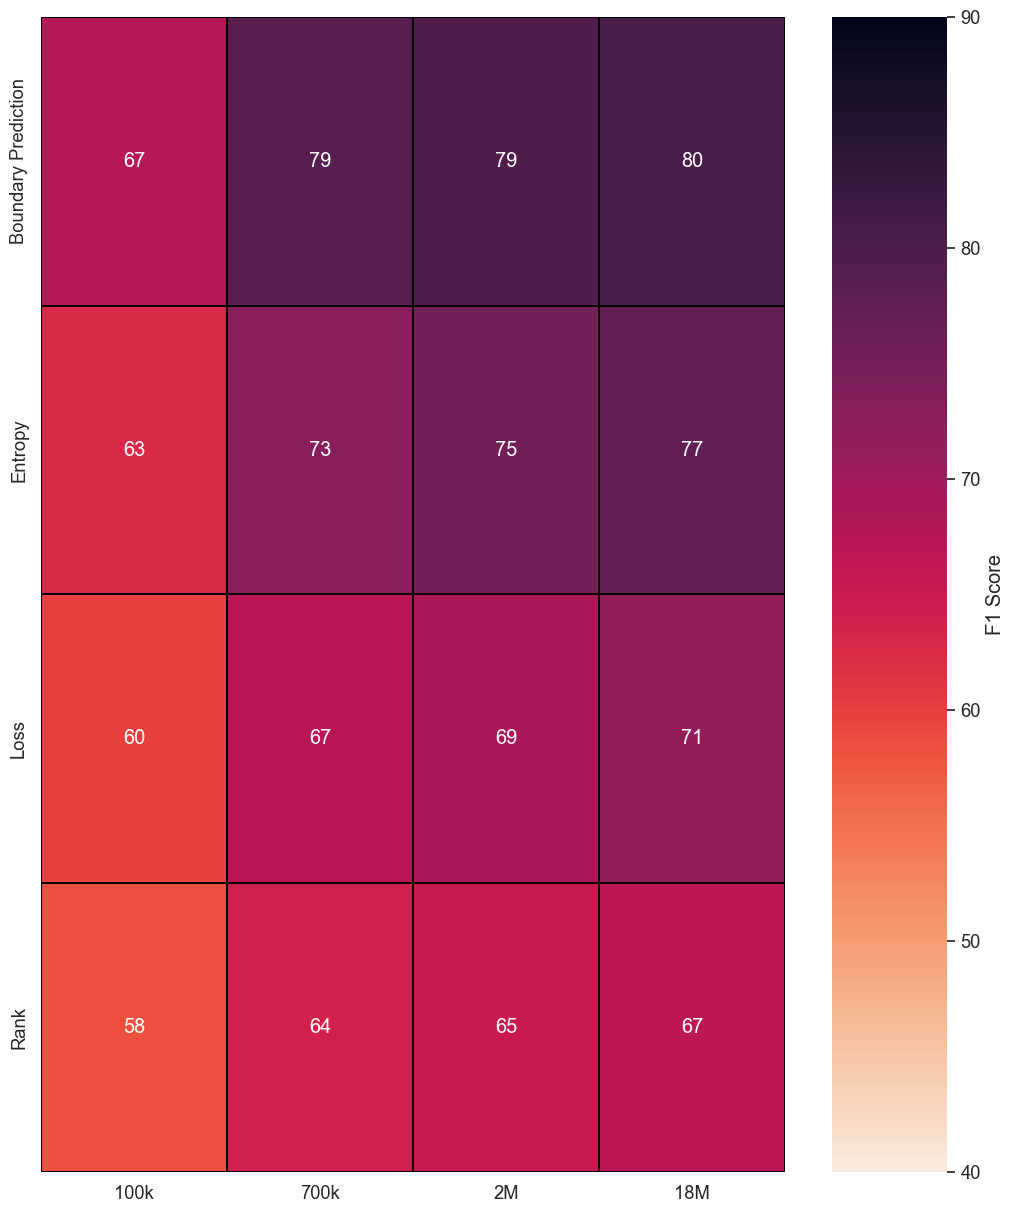

In [13]:
plot_comparison_heatmap(columns, 'spike', 'English')